<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/nn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

file_path = "drive/MyDrive/Code/rawData/data_small.txt"
dataset = read_dataset(file_path)[1:]
print(dataset[:10])

[('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there'), ('Greet', 'Hi how can I help you?')]


In [2]:
intent_counts = {}
for intent, _ in dataset:
    if intent not in intent_counts:
        intent_counts[intent] = 0
    intent_counts[intent] += 1
print(intent_counts)
print(f"Number of examples in dataset: {len(dataset)}")

{'Greet': 53, 'Farewell': 66, 'Inquiry': 50, 'Feedback': 50, 'Complaint': 38, 'Request': 50, 'Navigation': 58}
Number of examples in dataset: 365


In [3]:
all_sentences = set(sentence for intent, sentence in dataset)
print(f"All unique sentences count: {len(all_sentences)}")

All unique sentences count: 355


In [4]:
# Check for duplicates
# from collections import Counter
# word_counts = Counter(sentence for intent, sentence in dataset)
# word_counts

In [5]:
from itertools import chain

all_words = set(chain(*[sentence.lower().split(" ") for intent, sentence in dataset]))
print(f"All unique sentences count: {len(all_words)}")

All unique sentences count: 723


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
word_to_index = {char: i for i, char in enumerate(all_words)}
print(f"No of words: {len(all_words)}")
print(word_to_index.items())

No of words: 723
dict_items([('hi', 0), ('new?', 1), ('bookmark', 2), ('york', 3), ('plumber?', 4), ('support?', 5), ('its', 6), ('delivery', 7), ('wait', 8), ('music', 9), ('hotel?', 10), ('upload', 11), ('could', 12), ('responsive.', 13), ('now!', 14), ('table', 15), ('innovative', 16), ('bill.', 17), ('issues.', 18), ('birthday?', 19), ('browsing', 20), ('thriving', 21), ('experience.', 22), ('do', 23), ('i', 24), ('looking', 25), ("you've", 26), ("i've", 27), ('section.', 28), ('unclear', 29), ('pm.', 30), ('paths', 31), ('information', 32), ('add', 33), ('howdy', 34), ('city?', 35), ('up!', 36), ('friend', 37), ('up?', 38), ('annoying.', 39), ('advanced', 40), ('trouble', 41), ('population', 42), ('whenever', 43), ('using', 44), ('issue.', 45), ('professional', 46), ('audio', 47), ('topic?', 48), ('future', 49), ('goodnight', 50), ('curve', 51), ('drive?', 52), ('restaurants', 53), ('historical', 54), ('job', 55), ('is', 56), ('help.', 57), ('serve', 58), ('yourself', 59), ('an', 

In [8]:
all_intents = set(intent for intent, _ in dataset[1:])
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {intent: i for i, intent in intent_to_index.items()}

print(f"No of intents {len(all_intents)}")
print(intent_to_index.items())
print(index_to_intent.items())

No of intents 7
dict_items([('Inquiry', 0), ('Feedback', 1), ('Greet', 2), ('Farewell', 3), ('Request', 4), ('Complaint', 5), ('Navigation', 6)])
dict_items([(0, 'Inquiry'), (1, 'Feedback'), (2, 'Greet'), (3, 'Farewell'), (4, 'Request'), (5, 'Complaint'), (6, 'Navigation')])


In [9]:
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(all_words)).to(device)
    for i, word in enumerate(sentence.lower().split(" ")):
        tensor[word_to_index[word]] = 1

    return tensor

In [10]:
# def tensor_to_sentence(tensor, all_words, word_to_index):
#     sentence = []
#     for i in range(len(tensor)):
#         if tensor[i] == 1:
#             word = list(word_to_index.keys())[list(word_to_index.values()).index(i)]
#             sentence.append(word)
#     return " ".join(sentence)

In [11]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, feature_transform=None, label_transform=None):
        self.data = dataset
        self.feature_transform = feature_transform
        self.label_transform = label_transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return label_transform[sample[0]], feature_transform(sample[1])
            # sample[1] = self.transform(sample[1])


In [12]:
feature_transform = transforms.Compose([
    sentence_to_tensor,
])
label_transform = intent_to_index

In [13]:
from sklearn.model_selection import train_test_split

training_data, test_data = train_test_split(dataset, test_size=0.4, random_state=42)

In [14]:
BATCH_SIZE = 32

train_dataset = CustomDataset(training_data, feature_transform=feature_transform, label_transform=label_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = CustomDataset(test_data, feature_transform=feature_transform, label_transform=label_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in cv dataset: {len(test_dataset)}")

Number of samples in training dataset: 219
Number of samples in cv dataset: 146


In [15]:
for batch, (intent, sentence) in enumerate(train_dataloader):
    if batch == 1:
      break
    print(sentence.shape)
    print(intent.shape)
    print(intent)
    print("-----------")

torch.Size([32, 723])
torch.Size([32])
tensor([3, 4, 4, 4, 2, 1, 5, 6, 3, 3, 0, 3, 6, 4, 4, 0, 0, 4, 6, 5, 1, 0, 3, 2,
        3, 1, 3, 4, 3, 0, 1, 0])
-----------


In [16]:
class MyModel(nn.Module):
    def __init__(self, word_count, intent_class_count, hidden_units):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(word_count, hidden_units)
        self.fc2 = nn.Linear(hidden_units, intent_class_count)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
def train_step(model, dataloader, optimizer, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [18]:
def test_step(model, dataloader, loss_fn):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (intent, sentence) in enumerate(dataloader):

        train_pred_logits = model(sentence)
        loss = loss_fn(train_pred_logits, intent)

        train_loss += loss.item()
        loss = loss_fn(train_pred_logits, intent)

        train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), dim=1)
        train_acc += (train_pred_class == intent).sum().item() / len(train_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, epochs, optimizer, loss_fn):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)

          test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn)

          print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )

          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)

    return results

In [20]:
model = MyModel(len(all_words), len(all_intents), 128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [21]:
model_0_results = train(model, train_dataloader, test_dataloader, 100, optimizer, loss_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9383 | train_acc: 0.1738 | test_loss: 1.9246 | test_acc: 0.3090
Epoch: 2 | train_loss: 1.8927 | train_acc: 0.5916 | test_loss: 1.9010 | test_acc: 0.4500
Epoch: 3 | train_loss: 1.8460 | train_acc: 0.7978 | test_loss: 1.8719 | test_acc: 0.5597
Epoch: 4 | train_loss: 1.7884 | train_acc: 0.8628 | test_loss: 1.8340 | test_acc: 0.5896
Epoch: 5 | train_loss: 1.7106 | train_acc: 0.8896 | test_loss: 1.7824 | test_acc: 0.6694
Epoch: 6 | train_loss: 1.6146 | train_acc: 0.9021 | test_loss: 1.7183 | test_acc: 0.6882
Epoch: 7 | train_loss: 1.4942 | train_acc: 0.9233 | test_loss: 1.6392 | test_acc: 0.7194
Epoch: 8 | train_loss: 1.3581 | train_acc: 0.9456 | test_loss: 1.5484 | test_acc: 0.7319
Epoch: 9 | train_loss: 1.2135 | train_acc: 0.9626 | test_loss: 1.4519 | test_acc: 0.7382
Epoch: 10 | train_loss: 1.0524 | train_acc: 0.9724 | test_loss: 1.3440 | test_acc: 0.7569
Epoch: 11 | train_loss: 0.9005 | train_acc: 0.9911 | test_loss: 1.2386 | test_acc: 0.7569
Epoch: 12 | train_l

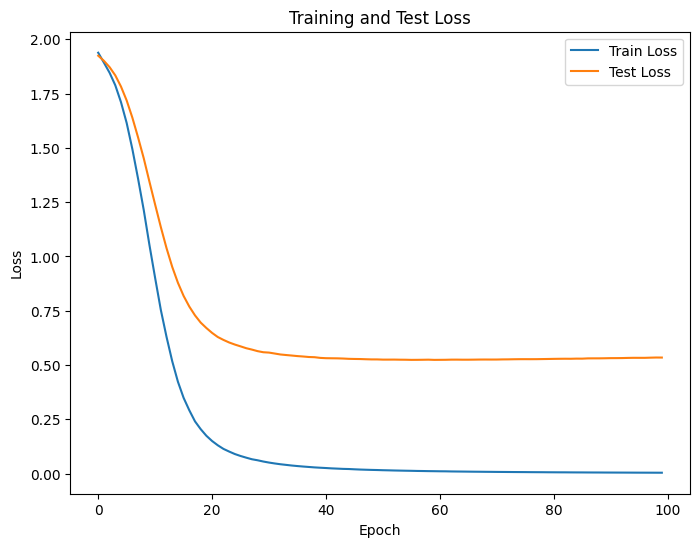

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(model_0_results["train_loss"], label="Train Loss")
ax.plot(model_0_results["test_loss"], label="Test Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Test Loss")
ax.legend()
plt.show()

In [23]:
def predict(model, input_data):
    with torch.no_grad():
        pred_logits = model(input_data)
        pred_class = torch.argmax(torch.softmax(pred_logits, dim=0), dim=0)

        return index_to_intent[pred_class.item()]

In [24]:
print(predict(model,  sentence_to_tensor("hI frIend bye see ya")))

Farewell
